## Import Libraries

In [103]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

## Load the Data

In [104]:
df = pd.read_csv("final_data_cleaned.csv")

In [105]:
df.shape

(6397, 19)

In [106]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,8,Manchester United,Defender Centre-Back,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758.0,47.0,13.0,0.0,2000000.0,2000000.0
1,10,Manchester United,Defender Left-Back,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132.0,182.0,15.0,3.0,22000000.0,22000000.0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [107]:
# uniqeness
df[df.duplicated()]

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [108]:
# Completeness
df.isnull().sum()

Unnamed: 0             0
team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [109]:
# Accurecy types
df.dtypes

Unnamed: 0               int64
team                    object
position                object
height                 float64
age                    float64
appearance             float64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played         float64
days_injured           float64
games_injured          float64
award                  float64
current_value          float64
highest_value          float64
dtype: object

In [110]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
numerical_feats_2 = ['height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value']

cetegorical_feats_2 = ['team', 'position']

In [111]:
# looping through the categorical columns and counting them
# if a category is only 1, we will treat it as an outlier
for i in cetegorical_feats_2:
    print(df[i].value_counts())

team
Huddersfield Town    29
Orlando Pirates      27
Cardiff City         26
Portimonense SC      26
Watford FC           26
                     ..
Bayern Munich         2
Gaziantep FK          2
Manchester City       2
FC Barcelona          2
Real Madrid           1
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1247
midfield-CentralMidfield       767
Attack Centre-Forward          667
midfield-DefensiveMidfield     616
Defender Right-Back            582
Defender Left-Back             566
Attack-RightWinger             469
midfield-AttackingMidfield     466
Attack-LeftWinger              427
Goalkeeper                     423
midfield-LeftMidfield           65
midfield-RightMidfield          61
Attack-SecondStriker            36
midfield                         3
Defender                         1
Attack                           1
Name: count, dtype: int64


In [112]:
# Calculate the frequency of each 'Type'
type_counts = df['team'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [113]:
# Calculate the frequency of each 'Type'
type_counts = df['position'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['position'].isin(type_counts[type_counts >= 2].index)]

In [114]:
# looping through the categorical columns and counting them
# if a category is only 1, we will treat it as an outlier
for i in cetegorical_feats_2:
    print(df[i].value_counts())

team
Huddersfield Town    29
Orlando Pirates      27
Watford FC           26
Blackpool FC         26
Portimonense SC      26
                     ..
Arsenal FC            4
Gaziantep FK          2
Bayern Munich         2
Manchester City       2
FC Barcelona          2
Name: count, Length: 373, dtype: int64
position
Defender Centre-Back          1247
midfield-CentralMidfield       767
Attack Centre-Forward          666
midfield-DefensiveMidfield     616
Defender Right-Back            582
Defender Left-Back             566
Attack-RightWinger             469
midfield-AttackingMidfield     466
Attack-LeftWinger              427
Goalkeeper                     423
midfield-LeftMidfield           65
midfield-RightMidfield          61
Attack-SecondStriker            36
midfield                         3
Name: count, dtype: int64


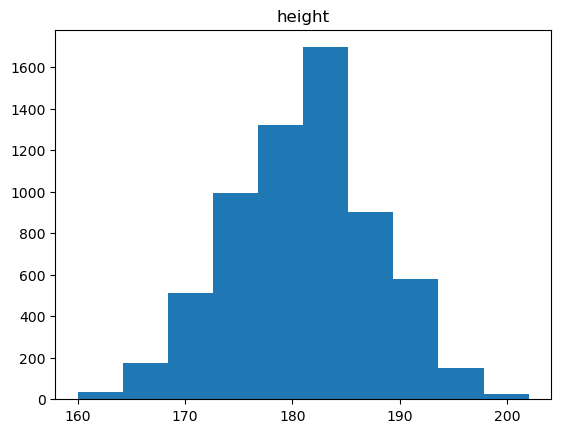

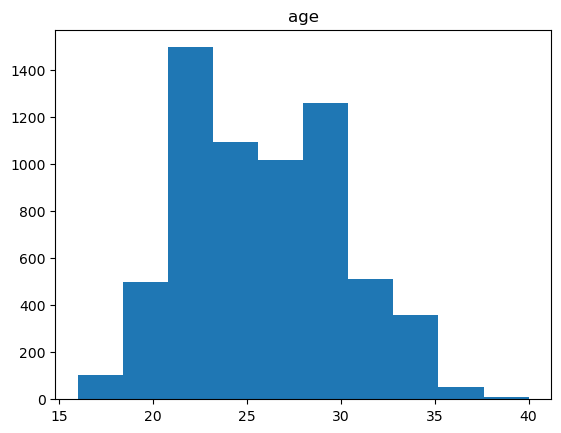

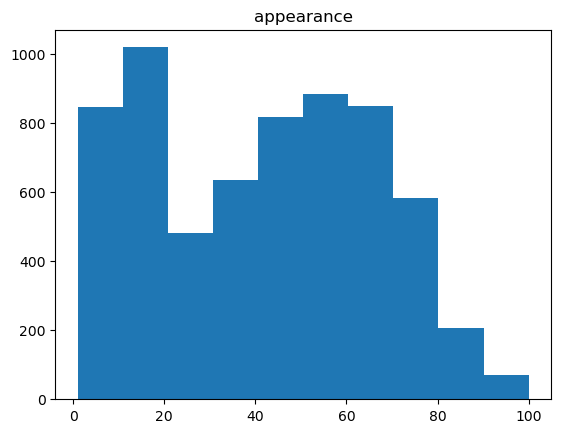

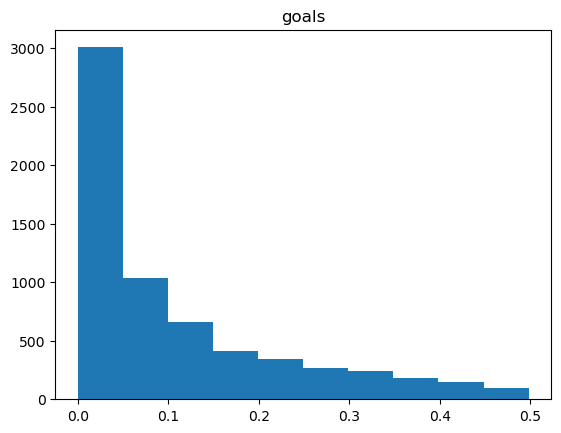

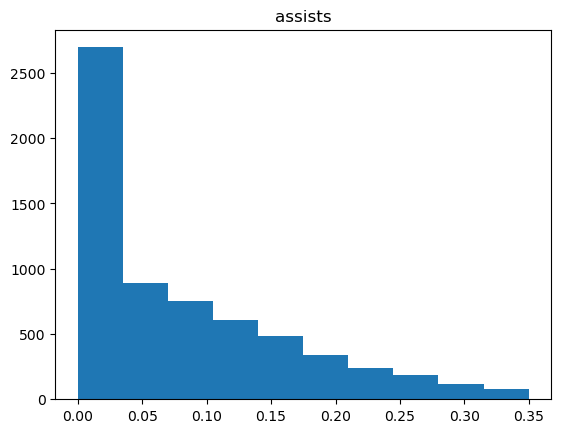

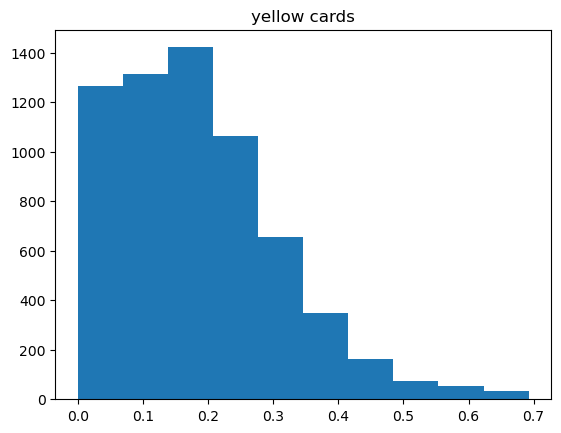

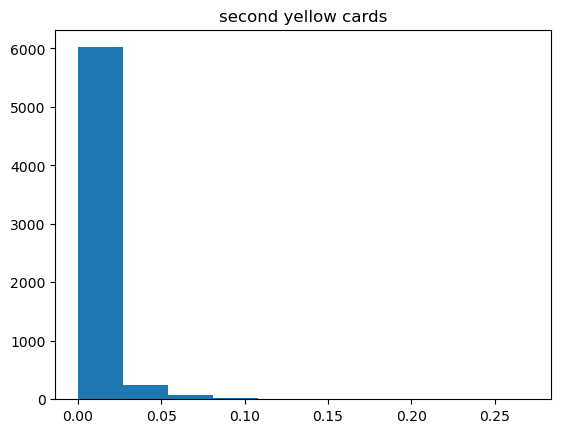

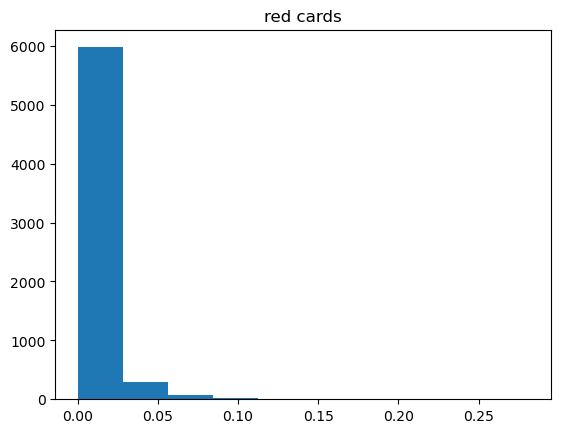

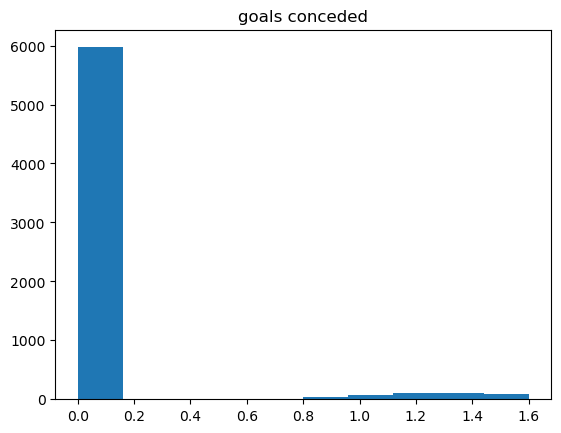

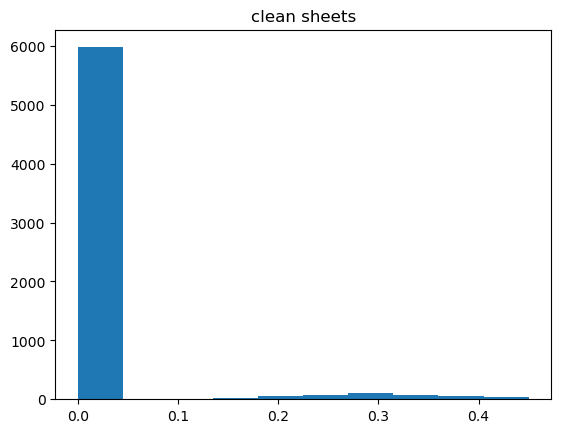

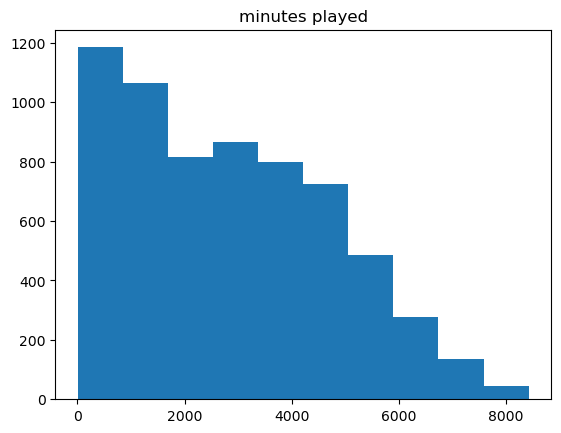

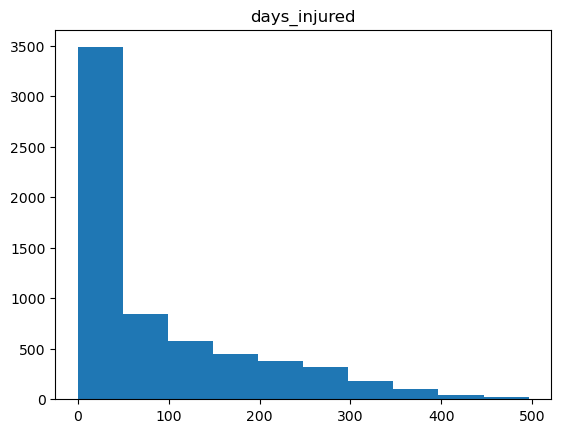

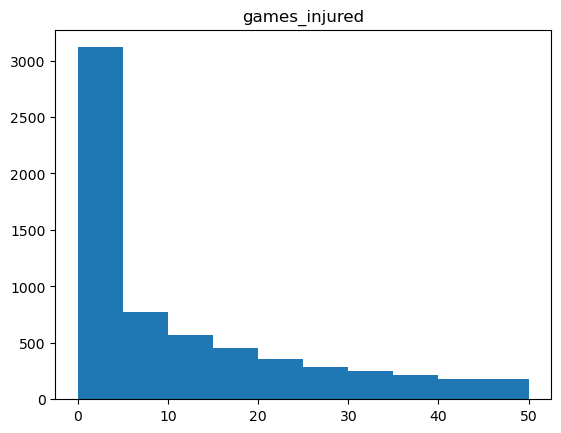

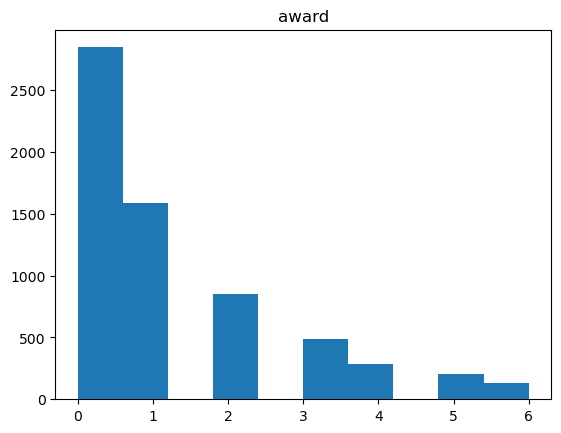

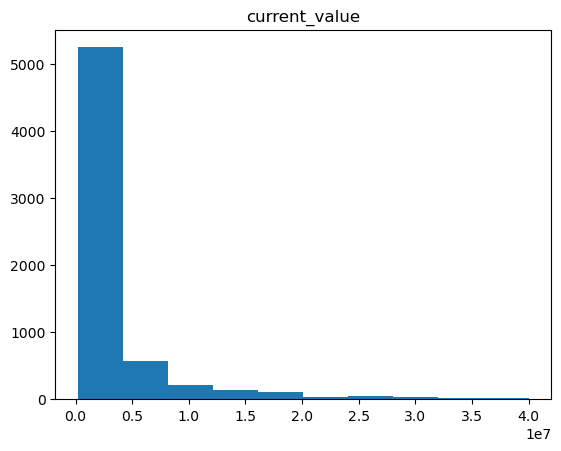

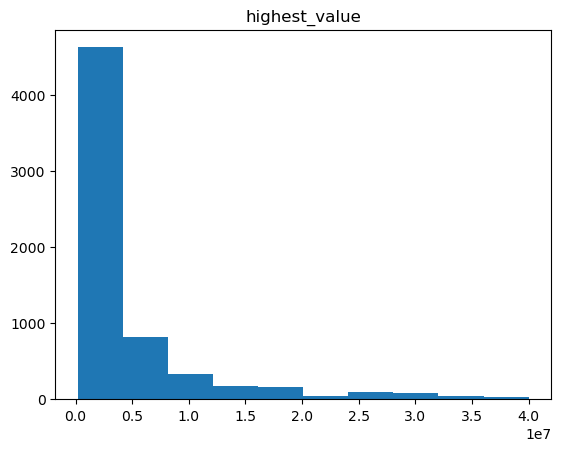

In [115]:
# looping through the numerical columns and plotting them
# to help detect outliers
for i in numerical_feats_2:
    plt.hist(df[i]);
    plt.title(i)
    plt.show()

In [116]:
df.columns

Index(['Unnamed: 0', 'team', 'position', 'height', 'age', 'appearance',
       'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards',
       'goals conceded', 'clean sheets', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value'],
      dtype='object')

In [117]:
# removing the unnamed column
df.drop(columns='Unnamed: 0', inplace=True)

In [118]:
df.columns

Index(['team', 'position', 'height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value'],
      dtype='object')

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [119]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Defender Centre-Back,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758.0,47.0,13.0,0.0,2000000.0,2000000.0
1,Manchester United,Defender Left-Back,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132.0,182.0,15.0,3.0,22000000.0,22000000.0


In [120]:
# numerical_feats_2

# cetegorical_feats_2

In [121]:
cetegorical_feats_2

['team', 'position']

In [122]:
df.shape

(6394, 18)

In [123]:
# one hot coding
df = pd.get_dummies(df, columns=cetegorical_feats_2)

In [124]:
df.shape

(6394, 403)

In [125]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
1,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False


#### 3. Feature selection

In [126]:
# sns.heatmap(correlation, annot=True);

In [127]:
correlation = df.corr()

In [128]:
print(correlation['current_value'].sort_values(ascending=False))

current_value           1.000000
highest_value           0.866758
appearance              0.408822
minutes played          0.408235
team_Aston Villa        0.161310
                          ...   
team_Orlando Pirates   -0.029575
team_Gwangju FC        -0.029921
position_Goalkeeper    -0.031118
goals conceded         -0.032060
age                    -0.130595
Name: current_value, Length: 403, dtype: float64


In [129]:
for i in correlation['current_value'].sort_values(ascending=False):
    print(i)

1.0
0.8667582641399648
0.4088216074673914
0.40823468887112085
0.1613097088518162
0.1507634580871357
0.1380324375387504
0.13748104637036793
0.131021273265285
0.13090550195688508
0.1259097880980194
0.12506963315208602
0.12108330343428336
0.11839266504818485
0.11559511778898383
0.11540993342282804
0.11355262358038011
0.11331553827306634
0.11199727621163268
0.11030032559040817
0.10990275112513642
0.10322878202737186
0.09750796219046468
0.09720859710910414
0.09319076767356936
0.09310218741884378
0.0904855818459967
0.08755969556091163
0.0871782418826087
0.08346845541797163
0.08236328543734285
0.08203957101386021
0.08194457339566724
0.07904446136290615
0.07724747935847338
0.07665531925846181
0.07604117349518007
0.07518789613606881
0.0737574725701498
0.07224194334695669
0.07146523993229993
0.07056029127510718
0.07019778072153218
0.06851588834842152
0.0666305073472641
0.06594010239848407
0.06340969186883069
0.0626992753244002
0.061806698222335935
0.060797469820602294
0.0538440837688976
0.053686

In [130]:
# Set the correlation threshold
threshold = 0.12  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['age', 'appearance', 'assists', 'minutes played', 'games_injured',
       'award', 'current_value', 'highest_value', 'team_Aston Villa',
       'team_Atalanta BC', 'team_Chelsea FC', 'team_Newcastle United',
       'team_SSC Napoli', 'team_Southampton FC'],
      dtype='object')

In [131]:
# selected_features = ['age', 'appearance', 'goals', 'assists', 'minutes played',
#        'days_injured', 'games_injured', 'award', 'current_value',
#        'highest_value', 'team_AFC Bournemouth', 'team_AS Monaco',
#        'team_Arsenal FC', 'team_Aston Villa', 'team_Atalanta BC',
#        'team_Brentford FC', 'team_Brighton &amp; Hove Albion',
#        'team_Everton FC', 'team_Leeds United', 'team_Leicester City',
#        'team_Nottingham Forest', 'team_Olympique Lyon', 'team_SL Benfica',
#        'team_SS Lazio', 'team_Southampton FC', 'team_Stade Rennais FC',
#        'team_VfL Wolfsburg']

In [132]:
df = df[selected_features]
df.head()

,age,appearance,assists,minutes played,games_injured,award,current_value,highest_value,team_Aston Villa,team_Atalanta BC,team_Chelsea FC,team_Newcastle United,team_SSC Napoli,team_Southampton FC
0,21.0,34.0,0.000000,2758.0,13.0,0.0,2000000.0,2000000.0,False,False,False,False,False,False
1,23.0,89.0,0.063096,7132.0,15.0,3.0,22000000.0,22000000.0,False,False,False,False,False,False
2,22.0,34.0,0.033507,2686.0,28.0,1.0,10000000.0,12000000.0,False,False,False,False,False,False
3,24.0,72.0,0.048439,5574.0,49.0,3.0,35000000.0,35000000.0,False,False,False,False,False,False
4,25.0,60.0,0.018817,4783.0,20.0,1.0,22000000.0,40000000.0,False,False,False,False,False,False


#### 4. Prepare train and test data

In [133]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
X.shape

(6394, 13)

## Buliding the Model

In [135]:
model = LinearRegression()

## Train the Model

In [136]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

## Test the Model

In [137]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [138]:
# model.coef_

In [139]:
# coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
# coeff_df

In [140]:
# print(model.intercept_) 

In [141]:
# coeff_df = pd.DataFrame(lasso_model.coef_,X.columns,columns=['Coefficient'])
# coeff_df

## Evaluating the Model 

1. Mean Square Error

In [142]:
y_base = [y_train.mean()] * len(y_test)

In [143]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 36330562505749.086


In [144]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 5689794985657.69
Mean Squared Error for testing: 5856301317688.708


2. Mean Absolute Error

In [145]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 3412855.404660746


In [146]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1368029.4767009604
Mean Absolute Error for testing: 1406289.4102534316


3. Root Mean Squared Error

In [147]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1847.3915136377416


In [148]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2385329.1147465776
Root Mean Squared Error for testing: 2419979.611006818


4. R Square

In [149]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7836504780980431
R Square for testing: 0.8380963199164677


#### Predictions vs. Real Values

In [150]:
predictions = model.predict(X_test_scaled)
predictions

array([ 173067.87719022,  418749.42332274, 2047993.69172177, ...,
       1655352.3977698 , 7147488.5637511 , 2555713.38492261])

In [151]:
Real_Values = np.array(y_test)
Real_Values

array([ 250000.,  300000., 1500000., ...,  900000., 8000000., 2300000.])

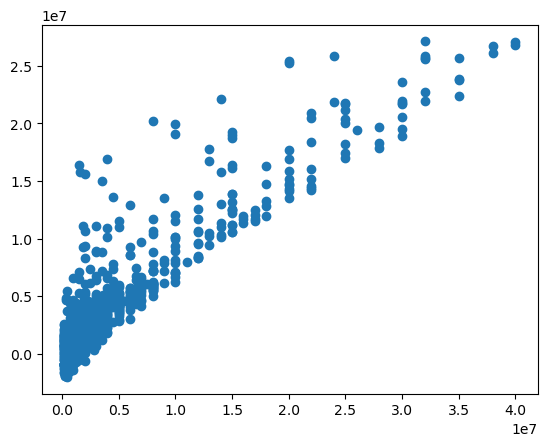

In [152]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

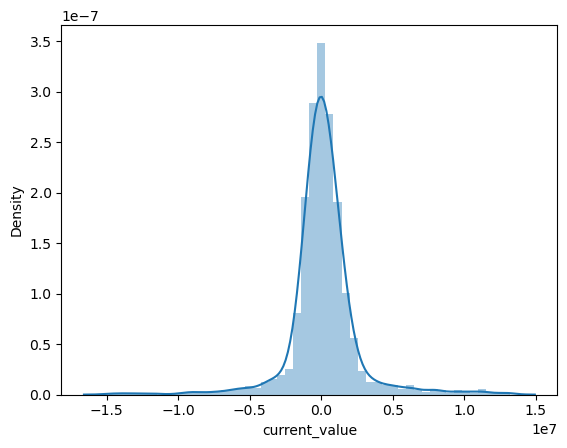

In [153]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution